In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


In [ ]:
# Load and explore the dataset
dataset = pd.read_csv("creditcard.csv")
print("Dataset Columns:", list(dataset.columns))
print("Any null values:", dataset.isnull().values.any())
print("Class label distribution:\n", pd.value_counts(dataset['Class'], sort=True))


Dataset Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Any null values: False
Class label distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


<ipython-input-2-06358a443152>:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print("Class label distribution:\n", pd.value_counts(dataset['Class'], sort=True))


<ipython-input-3-992ff969d0c9>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(dataset['Class'], sort=True)


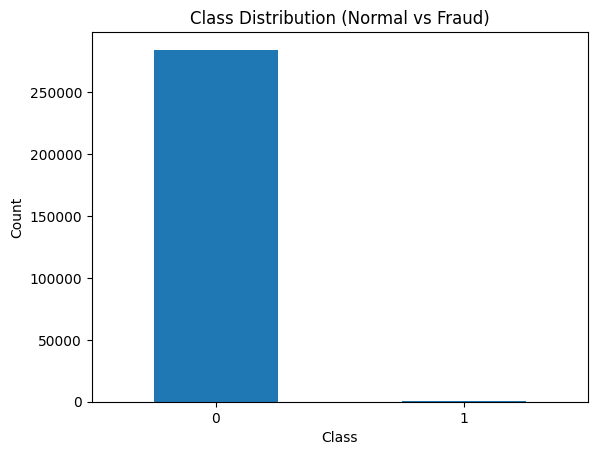

In [ ]:
# Visualize the class distribution
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Class Distribution (Normal vs Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

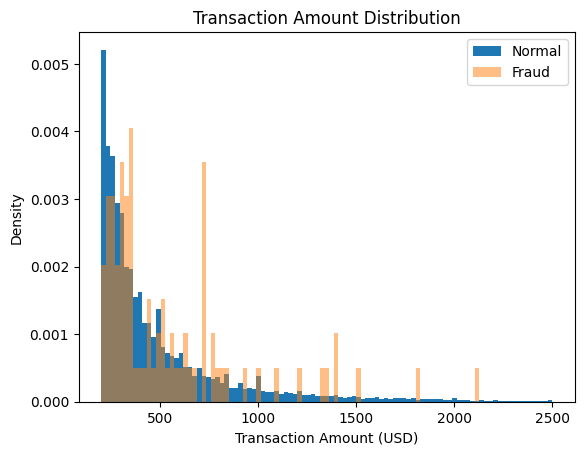

In [ ]:
# Visualize transaction amounts for normal and fraudulent transactions
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount (USD)")
plt.ylabel("Density")
plt.show()

In [ ]:
# Scale 'Time' and 'Amount' columns
scaler = StandardScaler()
dataset['Time'] = scaler.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = scaler.fit_transform(dataset['Amount'].values.reshape(-1, 1))


In [ ]:
# Prepare data for training and testing
raw_data = dataset.values
labels = raw_data[:, -1]  # Class labels
data = raw_data[:, 0:-1]  # Features


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2021
)

In [ ]:
# Normalize the data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# Filter only normal transactions (Class 0) for training
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

In [ ]:
# Autoencoder parameters
input_dim = normal_train_data.shape[1]
encoding_dim = 14
hidden_dim_1 = encoding_dim // 2
hidden_dim_2 = 4
learning_rate = 1e-7

In [ ]:
# Build the Autoencoder model
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │              35 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168 (4.56 KB)

 Trainable params: 1,168 (4.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Training callbacks
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.keras",
                                        monitor='val_loss', save_best_only=True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=True, verbose=1)


In [ ]:
# Train the Autoencoder
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(test_data, test_data),
    callbacks=[cp, early_stop]
)

Epoch 1/50
3547/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0236 - loss: 0.0234
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0236 - loss: 0.0233 - val_accuracy: 0.0019 - val_loss: 2.0504e-05
Epoch 2/50
3531/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0568 - loss: 1.9672e-05
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0568 - loss: 1.9670e-05 - val_accuracy: 0.2168 - val_loss: 2.0038e-05
Epoch 3/50
3544/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0650 - loss: 1.9285e-05
Epoch 3: val_loss did not improve from 0.00002
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0650 - loss: 1.9286e-05 - val_accuracy: 0.0420 - val_loss: 2.0218e-05
Epoch 4/50
3549/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0669 - loss: 1.9333e-05
Epoch 4: val_loss improved from

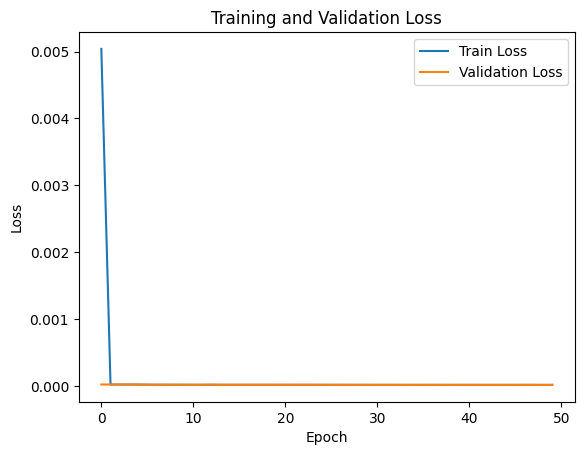

In [ ]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Detect anomalies on test data
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# Set threshold based on 99th percentile of training loss
train_predictions = autoencoder.predict(normal_train_data)
train_loss = np.mean(np.power(normal_train_data - train_predictions, 2), axis=1)
threshold = np.percentile(train_loss, 99)

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [ ]:
# Predict anomalies
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_labels})
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y


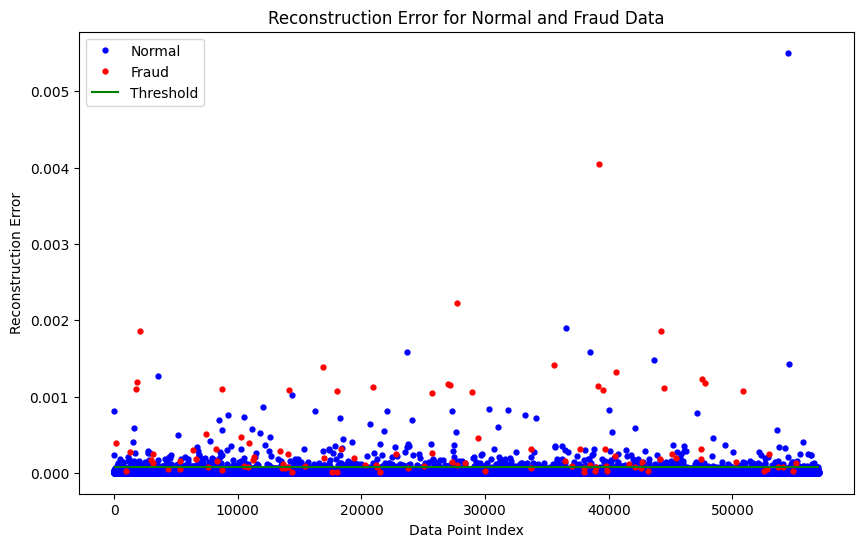

In [ ]:
# Plot reconstruction error for normal and fraud data
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(10, 6))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', linestyle='',
            ms=3.5, label="Fraud" if name == 1 else "Normal", color="red" if name == 1 else "blue")

# Plot the threshold line
ax.hlines(threshold, xmin=0, xmax=len(error_df), colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Normal and Fraud Data")
plt.xlabel("Data Point Index")
plt.ylabel("Reconstruction Error")
plt.show()


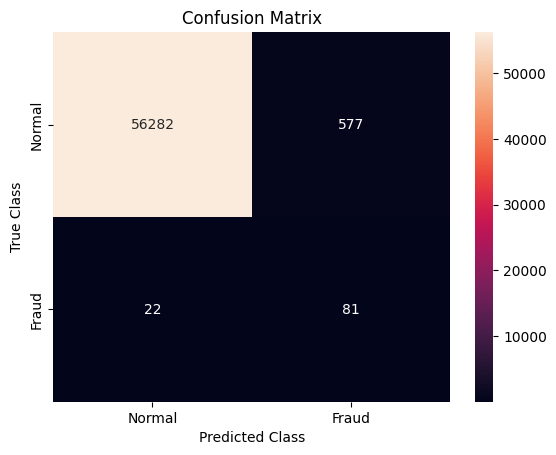

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(error_df['True_class'], error_df['pred'])
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Print performance metrics
print("Accuracy:", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall:", recall_score(error_df['True_class'], error_df['pred']))
print("Precision:", precision_score(error_df['True_class'], error_df['pred']))

Accuracy: 0.9894842175485411
Recall: 0.7864077669902912
Precision: 0.12310030395136778


In [ ]:
history